# Simulate eBOSS spectra in Specsim

Start notebook in Python 3 kernel

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

import specsim.simulator
import specsim.config

from specsim.instrument import Instrument
from astropy.table import Table
from astropy.io import ascii

### Load eBOSS stellar spectra 

In [3]:
from astropy.table import Table
from astropy.io import ascii

In [4]:
# Downloaded spectra from SAS
star1  = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0001.fits')
star22 = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0022.fits')
star27 = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0027.fits')
star30 = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0030.fits')
star36 = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0036.fits')

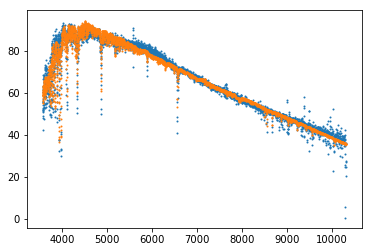

In [34]:
# Looks like these already contain the model???
plt.scatter(10**star22['loglam'], star22['flux'], s=1)
plt.scatter(10**star22['loglam'], star22['model'], s=1)
plt.show()

#### Put data in format to be read in eboss.yaml

`Needs to extend at least beyond:
    min: 3000.0
    max: 10890.0`

#### Write model to file and move to `/Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/` to be read by config file

In [7]:
def write(data, column, filename=None):
    
    wlen, model = 10**data['loglam'], data[column]
    
    lo = False
    
    if wlen[0] > 3005.0:
        lo_wlen = np.arange(2999.9, np.min(wlen), 0.1)
        lo_model = np.ones(len(lo_wlen))*model[0]
        lo_wlen = np.concatenate((lo_wlen, wlen))
        lo_model = np.concatenate((lo_model, model))
        new_model = Table([lo_wlen, lo_model], names=('WAVELENGTH', 'FLUX'))
        lo = True
        
    if wlen[-1] < 10895.0:
        hi_wlen = np.arange(np.max(wlen), 10891.1, 0.1)
        hi_model = np.ones(len(hi_wlen))*model[-1]
        if lo:
            hi_wlen = np.concatenate((lo_wlen, hi_wlen))
            hi_model = np.concatenate((lo_model, hi_model))
            new_model = Table([hi_wlen, hi_model], names=('WAVELENGTH', 'FLUX'))
        else:
            hi_wlen = np.concatenate((wlen, hi_wlen))
            hi_model = np.concatenate((model, hi_model))
            new_model = Table([hi_wlen, hi_model], names=('WAVELENGTH', 'FLUX'))
    
            
    else:
        new_model = Table([wlen, flux], names=('WAVELENGTH', 'FLUX'))

    ''' 
    lo_model = np.ones(len(lo_wlen))*model[0]
    hi_model = np.ones(len(hi_wlen))*model[-1]

    new_model_wlen = np.concatenate((lo_wlen, wlen, hi_wlen))a
    new_model_flux = np.concatenate((lo_model, model, hi_model))

    new_model = Table([new_model_wlen, new_model_flux], names=('WAVELENGTH', 'FLUX'))
    '''       
    
    if filename:
        new_model.write(filename, format='ascii', overwrite=True)
                
    plt.scatter(10**star1['loglam'], star1[column], s=1)
    plt.scatter(new_model['WAVELENGTH'], new_model['FLUX'], s=1)
    
    plt.xlim(6500, 6600)
    
    return(new_model)

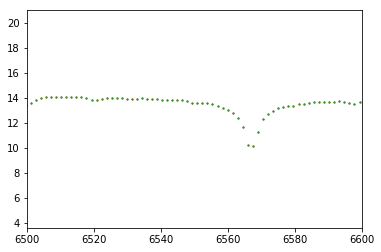

In [16]:
# input model and model written to file seem to match...
star1_model = write_model(star1)

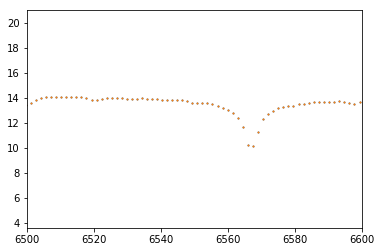

In [18]:
plt.scatter(star1_model['WAVELENGTH'], star1_model['FLUX'], s=1)
plt.scatter(10**star1['loglam'], star1['model'], s=1)
plt.xlim(6500, 6600);

In [55]:
!mv star1.dat /Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/

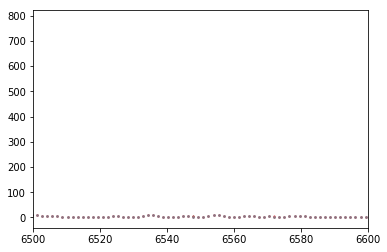

In [9]:
star22_sky = write(star22, 'sky', 'star22_sky.dat')
star27_sky = write(star27, 'sky', 'star27_sky.dat')
star30_sky = write(star30, 'sky', 'star30_sky.dat')
star36_sky = write(star36, 'sky', 'star36_sky.dat')

In [13]:
!mv star36_sky.dat /Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/

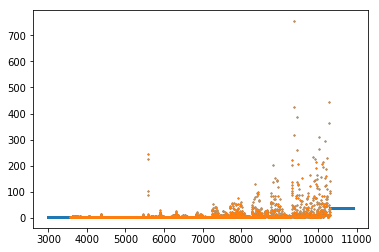

In [14]:
plt.scatter(star22_sky['WAVELENGTH'], star22_sky['FLUX'], s=1)
plt.scatter(10**star22['loglam'], star22['sky'], s=1)
plt.show()

In [15]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
simulator.simulate()

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


In [20]:
simulator.simulated[:2] # get sky electrons and convert to flux density to compare to model sky flux?

wavelength,source_flux [1],fiberloss [1],source_fiber_flux [1],sky_fiber_flux [1],num_source_photons [1],num_sky_photons [1],num_source_electrons_b [1],num_sky_electrons_b [1],num_dark_electrons_b [1],read_noise_electrons_b [1],num_source_electrons_r [1],num_sky_electrons_r [1],num_dark_electrons_r [1],read_noise_electrons_r [1]
Angstrom,erg / (Angstrom cm2 s),,erg / (Angstrom cm2 s),erg / (Angstrom cm2 s),,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
3000.0,1.24942731857e-16,0.51099,3.67386673407e-17,3.45689293948e-17,22.5329503605,21.2021835971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3000.1,1.24942731857e-16,0.51099,3.67386673407e-17,3.45689293948e-17,22.5337014589,21.2028903365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compare fluxes and variance

In [6]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']
b_ivar, r_ivar = blue_output['flux_inverse_variance'], red_output['flux_inverse_variance']

In [35]:
# star 1
ascii.write([b_wlen, b_flux[:,0], b_ivar[:,0]], 'blue_output.dat', overwrite=True)
ascii.write([r_wlen, r_flux[:,0], r_ivar[:,0]], 'red_output.dat', overwrite=True)

In [5]:
# set star to be read in config file (make sure filename matches star file in eboss.yaml)
def compare_fluxes(model, star):
    
    simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
    simulator.atmosphere
    simulator.simulate()
    
    blue_output = simulator.camera_output[0]
    red_output = simulator.camera_output[1]
    
    sim = simulator.simulated

    b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
    b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']
    b_ivar, r_ivar = blue_output['flux_inverse_variance'], red_output['flux_inverse_variance']
    
    midpt = len(b_wlen)
    
    wlen = np.empty(len(b_wlen)+len(r_wlen))
    flux = np.copy(wlen)
    ivar = np.copy(wlen)
    wlen[0:midpt] = np.asarray(b_wlen)
    wlen[midpt:]  = np.asarray(r_wlen)
    flux[0:midpt] = np.asarray(b_flux.reshape(-1))
    flux[midpt:]  = np.asarray(r_flux.reshape(-1))
    ivar[0:midpt] = np.asarray(b_ivar.reshape(-1))
    ivar[midpt:]  = np.asarray(r_ivar.reshape(-1))
    
    #star_data = Table.read('/Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/'+filename, format='ascii')
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,7))
    ax1.scatter(wlen, flux * 1e17, s=1, label='simulated')
    ax1.scatter(10**model['loglam'], model['model'], s=1, label='model') # from SAS
    ax1.scatter(sim['wavelength'], sim['source_flux']*1e17, s=1, label='source_flux')
    #ax1.scatter(star1_model['WAVELENGTH'], star1_model['FLUX'], s=1, label='star1_model') # from config file
    ax1.set_xlabel('Wavelength [A]')
    ax1.set_ylabel('Flux [10^(-17) erg/s/cm^2/A]')
    #ax1.set_ylim(np.percentile(model['flux'], (0,99.9)))
    ax1.set_xlim(6500,6600)
    ax1.set_title(star+' flux')
    ax1.legend(loc=2)
    
    ax2.scatter(b_wlen, b_ivar*10**(-34), s=1, label='blue simulated')
    ax2.scatter(r_wlen, r_ivar*10**(-34), s=1, label='red simulated')
    ax2.scatter(10**model['loglam'], model['ivar'], s=1, label='model')
    ax2.set_xlabel('Wavelength [A]')
    ax2.set_ylabel('Inverse variance [A^2 cm^4 s^2 / erg^2]')
    #ax2.set_ylim(np.percentile(model['ivar'], (0,99)))
    ax2.set_title(star+' ivar')
    ax2.legend(loc=2)
    
    plt.show()

Plot blue and red separately - and compare to ivar from frame file rather than from model (since model is coadded)

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


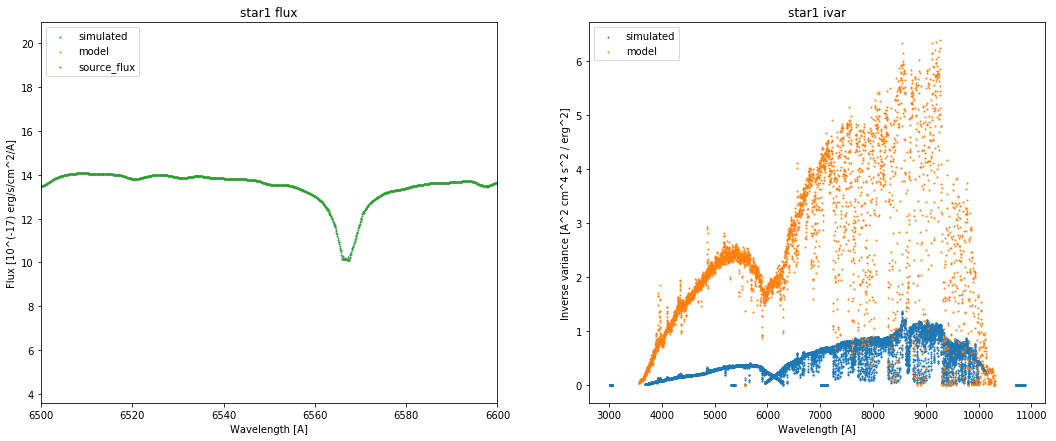

In [22]:
compare_fluxes(star1, 'star1') #eboss-spec-sky

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


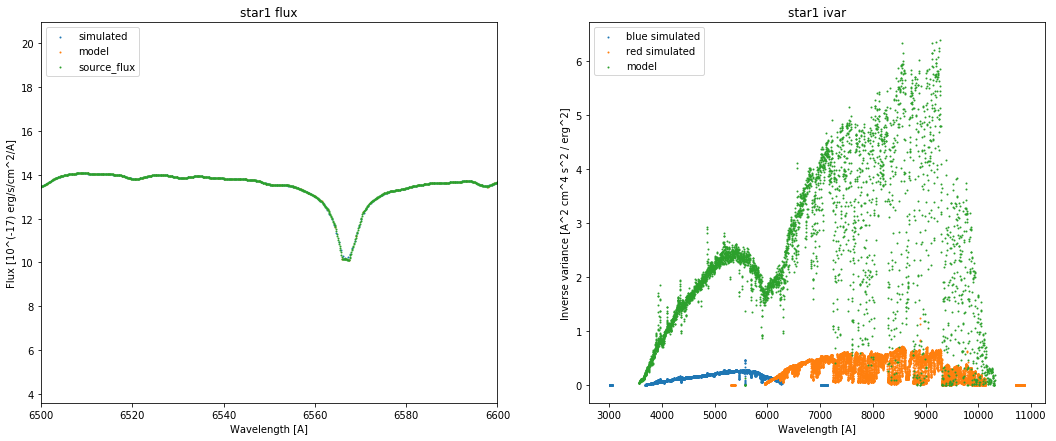

In [6]:
compare_fluxes(star1, 'star1') #star1_sky

# Comparison

### Compare to single exposure from frame file, add all exposures in frame files and see if it matches up with model (since ivar adds)

In [5]:
# read star 1 simulated data
blue_output = ascii.read('blue_output.dat')
red_output = ascii.read('red_output.dat')

In [39]:
# read frame files for star 1

import bossdata

finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

def get_frame_data(plate, mjd, fiber, expidx, camera):
    
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures
    
    print(spec_name)

    name = exposures.get_exposure_name(expidx, camera, 'spCFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
    header = spCFrame.header
    data = spCFrame.get_valid_data(np.array([fiber]), include_sky=True,use_ivar=True, pixel_quality_mask=None)[0]
    wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']

    return(header, wave, flux, sky, ivar)

In [73]:
plate = 4055
mjd = 55359
fiber = 1

expidx = 0

hd_b1_0, wave_b1_0, flux_b1_0, sky_b1_0, ivar_b1_0 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_0, wave_r1_0, flux_r1_0, sky_r1_0, ivar_r1_0 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [74]:
hd_b1_0


SIMPLE  =                    T / conforms to FITS standard
BITPIX  =                  -32 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                 4128 /
NAXIS2  =                  500 /
EXTEND  =                    T /
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey
FILENAME= 'sdR-b1-00116475.fit'
CAMERAS = 'b1      '           /
NGUIDE  =                   56 / Number of guider frames during exposure
SEEING20=              1.29960 / 20% seeing during exposure (arcsec)
SEEING50=              1.40220 / 50% seeing during exposure (arcsec)
SEEING80=              1.57400 / 80% seeing during exposure (arcsec)
RMSOFF20=           0.00986510 / 20% RMS offset of guide fibers (arcsec)
RMSOFF50=            0.0149112 / 50% RMS offset of guide fibers (arcsec)
RMSOFF80=            0.0211376 / 80% RMS offset of guide fibers (arcsec)
EXPOSURE=               116475
DAQVER  = '1.2.14  '
CAMDAQ  = '1.4.7:38'
SUBFRAME= '' / the subframe readout c

In [24]:
star1_b1_expid0 = Table([wave_b1_0.data, flux_b1_0.data, sky_b1_0.data, ivar_b1_0.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
star1_r1_expid0 = Table([wave_r1_0.data, flux_r1_0.data, sky_r1_0.data, ivar_r1_0.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
ascii.write(star1_b1_expid0, 'star1_b1_expid0.fits')
ascii.write(star1_r1_expid0, 'star1_r1_expid0.fits')

In [62]:
hd_b1_2, wave_b1_2, flux_b1_2, sky_b1_2, ivar_b1_2 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=2, 
                                                           camera='b1')
hd_r1_2, wave_r1_2, flux_r1_2, sky_r1_2, ivar_r1_2 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=2, 
                                                           camera='r1')
star1_b1_expid2 = Table([wave_b1_2.data, flux_b1_2.data, sky_b1_2.data, ivar_b1_2.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
star1_r1_expid2 = Table([wave_r1_2.data, flux_r1_2.data, sky_r1_2.data, ivar_r1_2.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
ascii.write(star1_b1_expid2, 'star1_b1_expid2.fits')
ascii.write(star1_r1_expid2, 'star1_r1_expid2.fits')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [70]:
hd_b1_3, wave_b1_3, flux_b1_3, sky_b1_3, ivar_b1_3 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=3, 
                                                           camera='b1')
hd_r1_3, wave_r1_3, flux_r1_3, sky_r1_3, ivar_r1_3 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=3, 
                                                           camera='r1')
star1_b1_expid3 = Table([wave_b1_3.data, flux_b1_3.data, sky_b1_3.data, ivar_b1_3.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
star1_r1_expid3 = Table([wave_r1_3.data, flux_r1_3.data, sky_r1_3.data, ivar_r1_3.data], 
                        names=('wavelength', 'flux', 'sky', 'ivar'))
ascii.write(star1_b1_expid3, 'star1_b1_expid3.fits')
ascii.write(star1_r1_expid3, 'star1_r1_expid3.fits')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


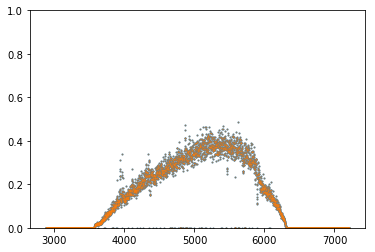

In [69]:
plt.scatter(wave_b1_2, ivar_b1_2.data, s=1)
plt.scatter(star1_b1_expid2['wavelength'], star1_b1_expid2['ivar'], s=1, alpha=0.3)
plt.ylim(0,1)
plt.show()

In [47]:
flux_b1_2 == star1_b1_expid2['flux']

masked_array(data = [-- -- -- ..., -- -- --],
             mask = [ True  True  True ...,  True  True  True],
       fill_value = True)

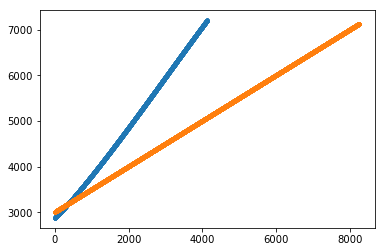

((4128,), (8252,))
(2878.2385, 7210.8521, 3011.1000000000004, 7136.6000000000004)


In [35]:
plt.plot(wave_b1_0, '.')
plt.plot(blue_output['wavelength'], '.')
plt.show()

print(wave_b1_0.shape, blue_output['wavelength'].shape )
print(np.min(wave_b1_0), np.max(wave_b1_0), np.min(blue_output['wavelength']), np.max(blue_output['wavelength']))

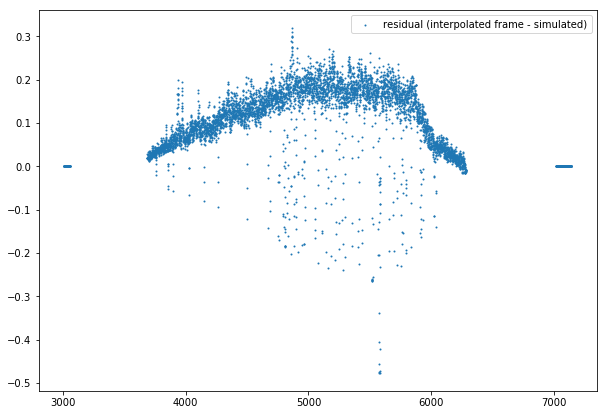

In [49]:
# interpolate frame data onto simulated wavelength grid and compare residuals (don't know if this is ok...)

b1_ivar_interp = np.interp(blue_output['wavelength'], wave_b1_0, ivar_b1_0)
plt.figure(figsize(10,7))
#plt.scatter(blue_output['wavelength'], b1_ivar_interp, s=1, label='interpolated frame ivar')
#plt.scatter(blue_output['wavelength'], blue_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated ivar')
plt.scatter(blue_output['wavelength'], b1_ivar_interp - blue_output['flux_inverse_variance'] * 1e-34, s=1, 
            label='residual (interpolated frame - simulated)')
plt.legend()
plt.show()

In [13]:
# global: plate, mjd, fiber specified here

plate = 4055
mjd = 55359
fiber = 1

def compare_frame_simulated(expidx, residual=False, combine_all=False):
    
    if combine_all:
                            
       
                                       
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,7))
                            
            for i in [0, 2, 3, 4, 5]:
                hd_b1, wave_b1, flux_b1, sky_b1, ivar_b1 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=i, 
                                                               camera='b1')
                hd_r1, wave_r1, flux_r1, sky_r1, ivar_r1 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=i, 
                                                               camera='r1')
                            
                if residual:
                            b1_ivar_interp = np.interp(blue_output['wavelength'], wave_b1, ivar_b1)
                            r1_ivar_interp = np.interp(red_output['wavelength'], wave_r1, ivar_r1)
                            
                            b1_res = b1_ivar_interp - blue_output['flux_inverse_variance'] * 1e-34
                            r1_res = r1_ivar_interp - red_output['flux_inverse_variance'] * 1e-34
                                                        
                            b1_res[np.isnan(b1_res)] = 0
                            r1_res[np.isnan(r1_res)] = 0
                            b_trim = np.abs(b1_res) < 1.0
                            r_trim = np.abs(r1_res) < 1.0
                            b1_res = b1_res[b_trim]
                            r1_res = r1_res[r_trim]
                            b_wlen = blue_output['wavelength'][b_trim]
                            r_wlen = red_output['wavelength'][r_trim]
                            
                            ax1.scatter(b_wlen, b1_res, s=1)
                            ax2.scatter(r_wlen, r1_res, s=1)
                            ax3.scatter(i, np.sum(abs(b1_res)/len(b1_res)), s=20, c='b')
                            ax3.scatter(i, np.sum(abs(r1_res))/len(r1_res), s=20, c='r')
                            ax1.set_ylim(-1,1)
                            ax2.set_ylim(-1,1)
                            ax1.set_title('B1')
                            ax2.set_title('R1')
                            ax3.set_title('Residual')
                        
                else:
                            ax1.scatter(wave_b1, ivar_b1, s=1)
                            ax1.scatter(blue_output['wavelength'], blue_output['flux_inverse_variance'] * 1e-34, s=1)
                            ax2.scatter(wave_r1, ivar_r1, s=1)
                            ax2.scatter(red_output['wavelength'], red_output['flux_inverse_variance'] * 1e-34, s=1)
                            ax1.set_title('B1')
                            ax2.set_title('R1')
                
            plt.show()        
        
        
    else:
        # get frame data
        hd_b1, wave_b1, flux_b1, sky_b1, ivar_b1 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                               camera='b1')
        hd_r1, wave_r1, flux_r1, sky_r1, ivar_r1 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                               camera='r1')

        # plot frame vs simulated for expid

        if residual:

            # can I plot residuals if they are on a different wavelength grid? Need to 
            # interpolate so they can be compared

            b1_ivar_interp = np.interp(blue_output['wavelength'], wave_b1, ivar_b1)
            r1_ivar_interp = np.interp(red_output['wavelength'], wave_r1, ivar_r1)

            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7), sharey=True)

            #plt.scatter(blue_output['wavelength'], b1_ivar_interp, s=1, label='interpolated frame ivar')
            #plt.scatter(blue_output['wavelength'], blue_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated ivar')
            ax1.scatter(blue_output['wavelength'], b1_ivar_interp - blue_output['flux_inverse_variance'] * 1e-34, s=1,
                        c='g', label='residual (interpolated frame b1 - simulated)')
            ax2.scatter(red_output['wavelength'], r1_ivar_interp - red_output['flux_inverse_variance'] * 1e-34, s=1, 
                        c='g', label='residual (interpolated frame r1 - simulated)')
            ax1.set_xlabel('Wavelength [A]')
            ax2.set_xlabel('Wavelength [A]')
            ax1.set_ylabel('Residual [A^2 cm^4 s^2 / erg^2]')
            ax1.set_ylim(-1,1)
            ax1.legend()
            ax2.legend()
            plt.show()

        else:

            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7), sharey=True)
            ax1.scatter(wave_b1, ivar_b1, s=1, label='frame b1, expid {:d}'.format(expidx))
            ax1.scatter(blue_output['wavelength'], blue_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated')
            ax2.scatter(wave_r1, ivar_r1, s=1, label='frame r1, expid {:d}'.format(expidx))
            ax2.scatter(red_output['wavelength'], red_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated')
            ax1.set_xlabel('Wavelength [A]')
            ax2.set_xlabel('Wavelength [A]')
            ax1.set_ylabel('Inverse variance [A^2 cm^4 s^2 / erg^2]')
            ax1.legend(loc=2)
            ax2.legend(loc=2)
            plt.show()

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


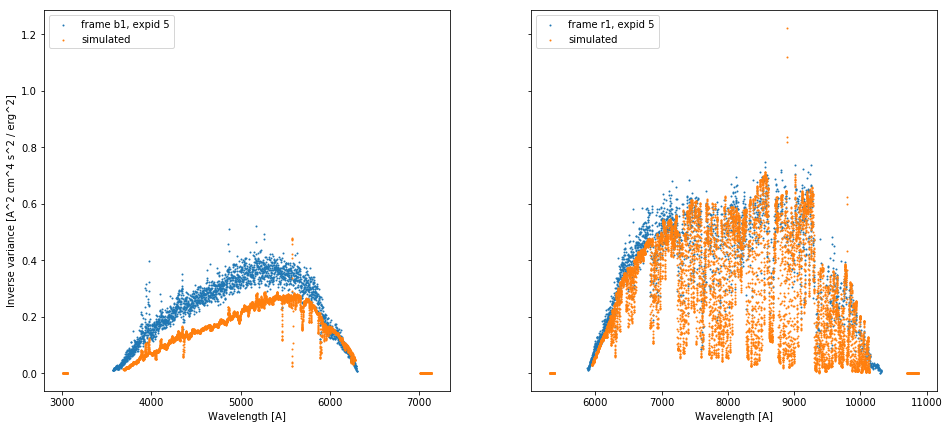

In [16]:
compare_frame_simulated(expidx=5, residual=False, combine_all=False)

## Look at residuals

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


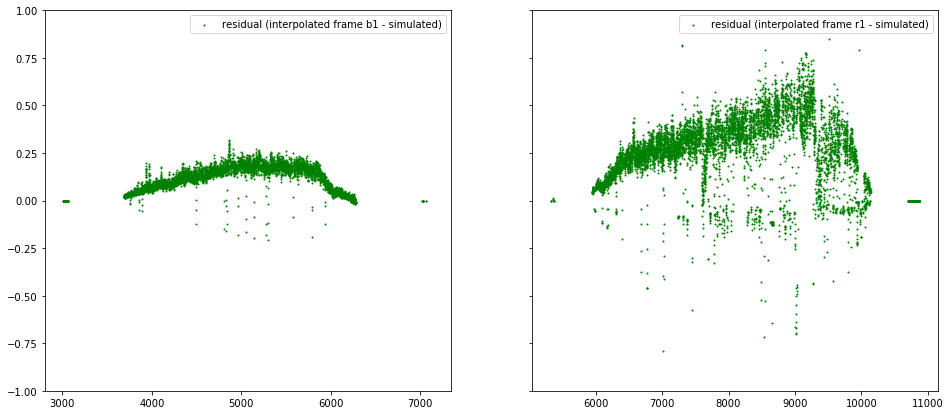

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


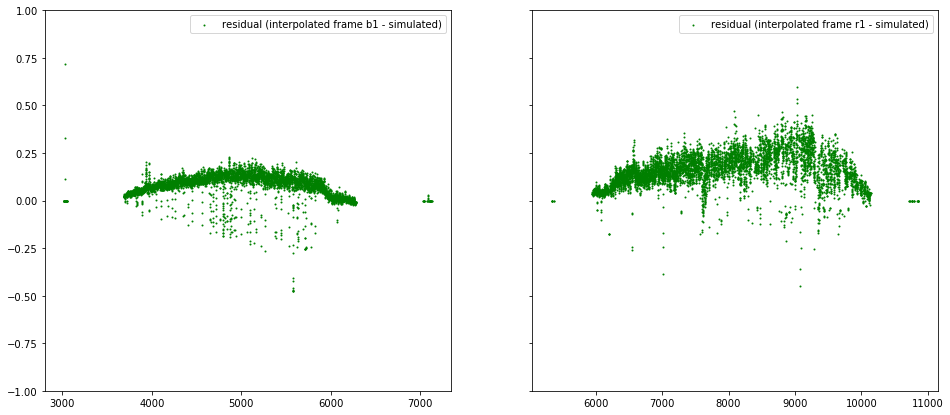

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


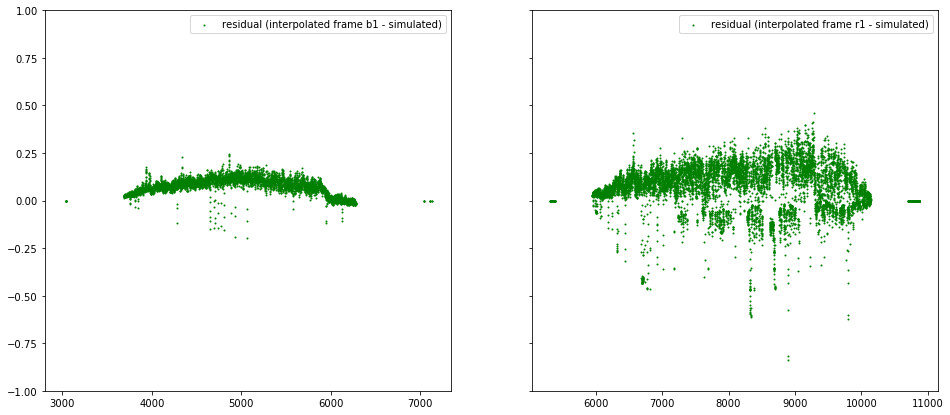

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


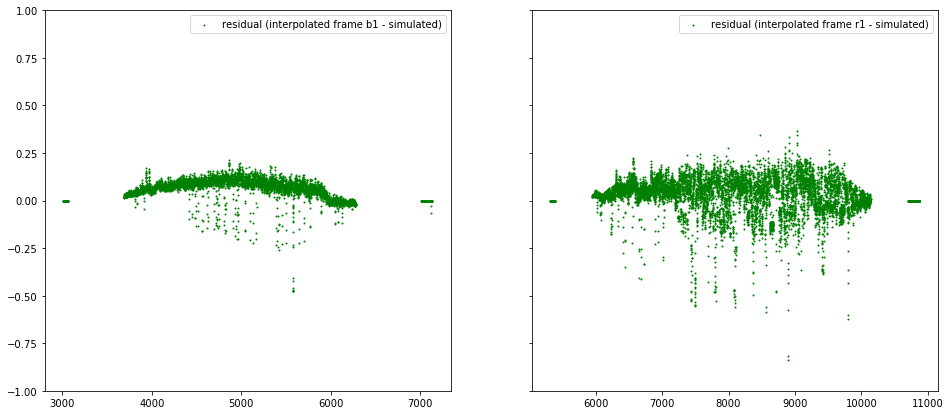

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


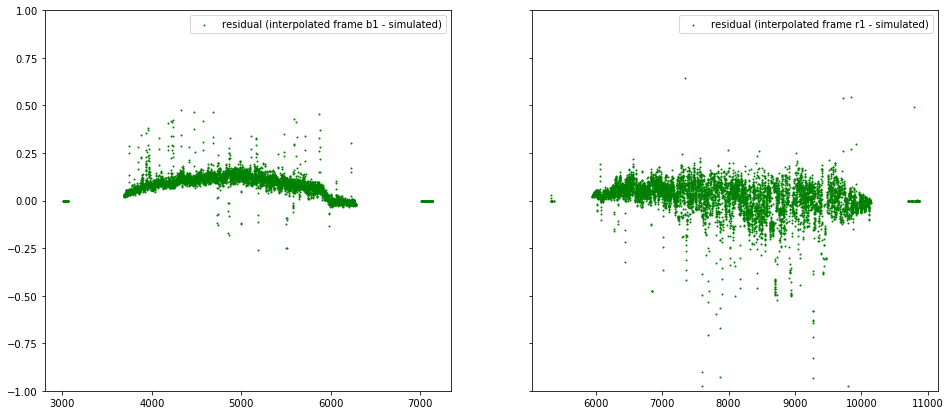

In [66]:
for i in [0, 2, 3, 4, 5]:
    compare_frame_simulated(expidx=i, residual=True)

## Look at fluxes

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


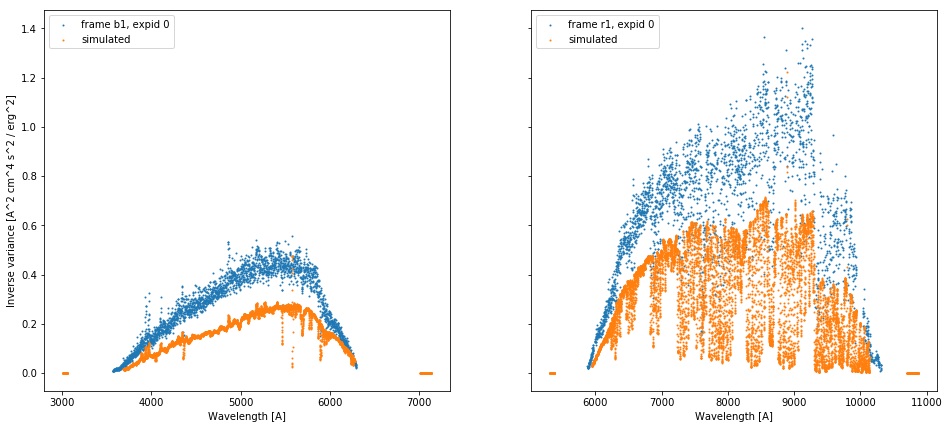

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


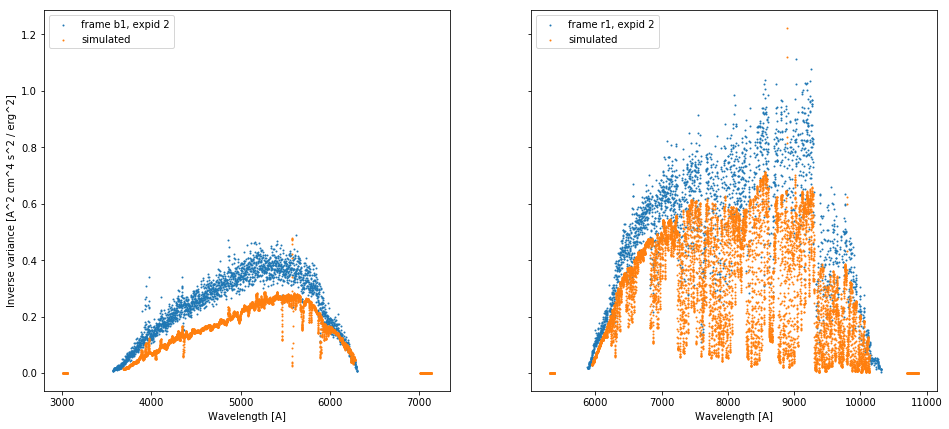

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


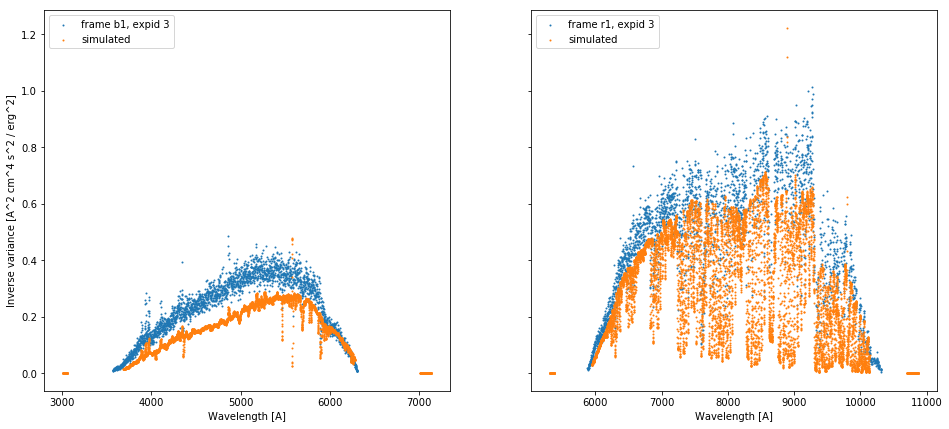

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


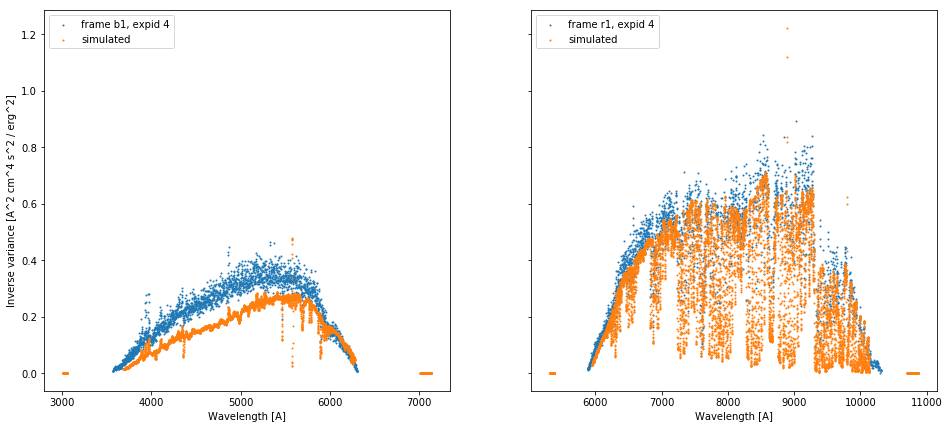

In [30]:
for i in [0, 2, 3, 4]:
    compare_frame_simulated(expidx=i)

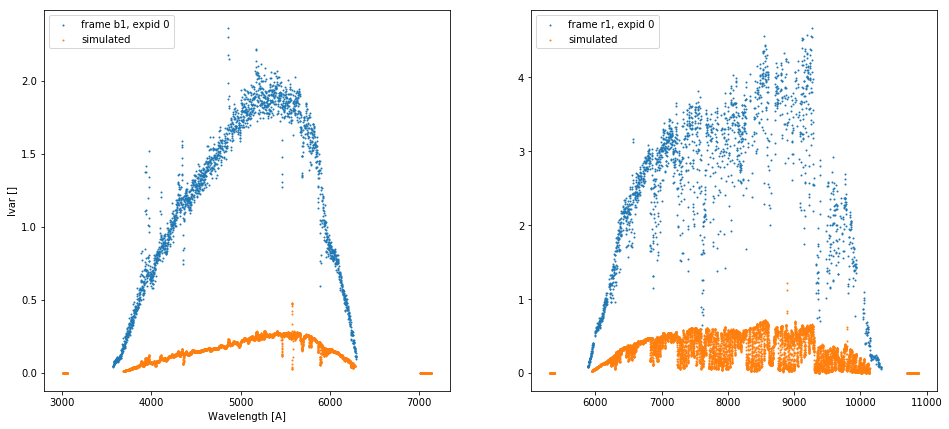

In [28]:
# Compare all exposures with blue/red output

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,7))
ax1.scatter(wave_b1_0, ivar_b1_0 + ivar_b1_2 + ivar_b1_3 + ivar_b1_4 + ivar_b1_5, s=1, label='frame b1, expid 0')
ax1.scatter(blue_output['wavelength'], blue_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated')
ax2.scatter(wave_r1_0, ivar_r1_0 + ivar_r1_2 + ivar_r1_3 + ivar_r1_4 + ivar_r1_5, s=1, label='frame r1, expid 0')
ax2.scatter(red_output['wavelength'], red_output['flux_inverse_variance'] * 1e-34, s=1, label='simulated')
ax1.set_xlabel('Wavelength [A]')
ax1.set_ylabel('Ivar []')
ax1.legend(loc=2)
ax2.legend(loc=2)
plt.show()

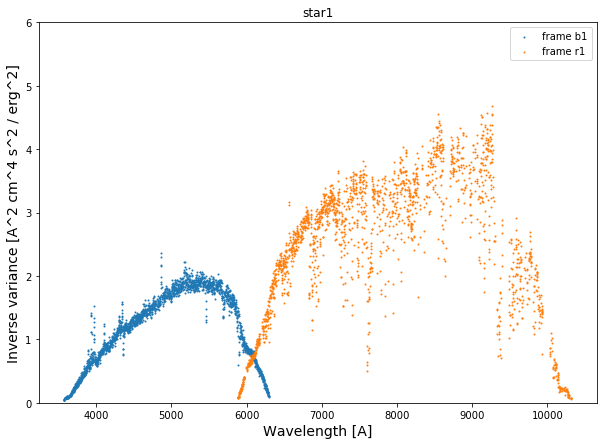

In [22]:
# Star 1, exposures 0 & 2

plt.figure(figsize=(10,7))
plt.scatter(wave_b1_0, ivar_b1_0 + ivar_b1_2 + ivar_b1_3 + ivar_b1_4 + ivar_b1_5, s=1, label='frame b1')
plt.scatter(wave_r1_0, ivar_r1_0 + ivar_r1_2 + ivar_r1_3 + ivar_r1_4 + ivar_r1_5, s=1, label='frame r1')
#plt.scatter(wave_b1_2, ivar_b1_2, s=1, label='frame b1')
#plt.scatter(wave_r1_2, ivar_r1_2, s=1, label='frame r1')
plt.title('Model', fontsize=14)
plt.xlabel('Wavelength [A]', fontsize=14)
plt.ylabel('Inverse variance [A^2 cm^4 s^2 / erg^2]', fontsize=14)
plt.title('star1')
plt.ylim(0, 6)
plt.legend()
plt.show()

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


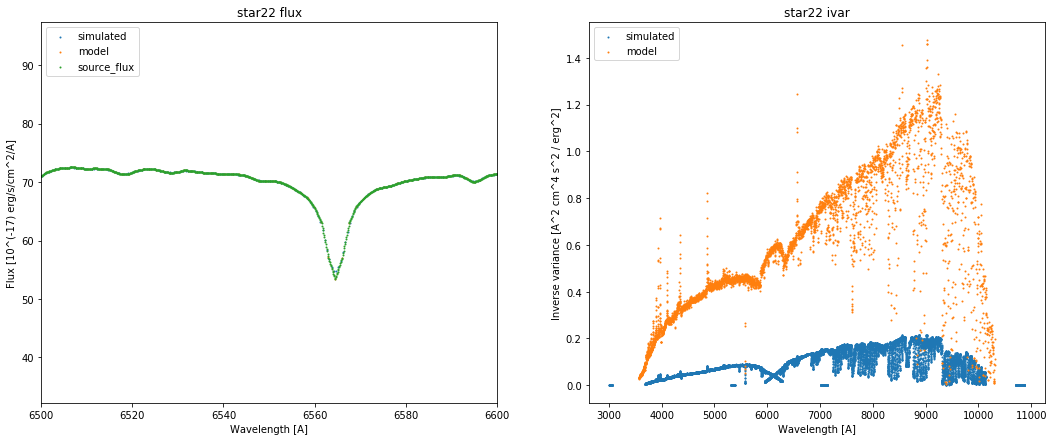

In [21]:
compare_fluxes(star22, 'star22')

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


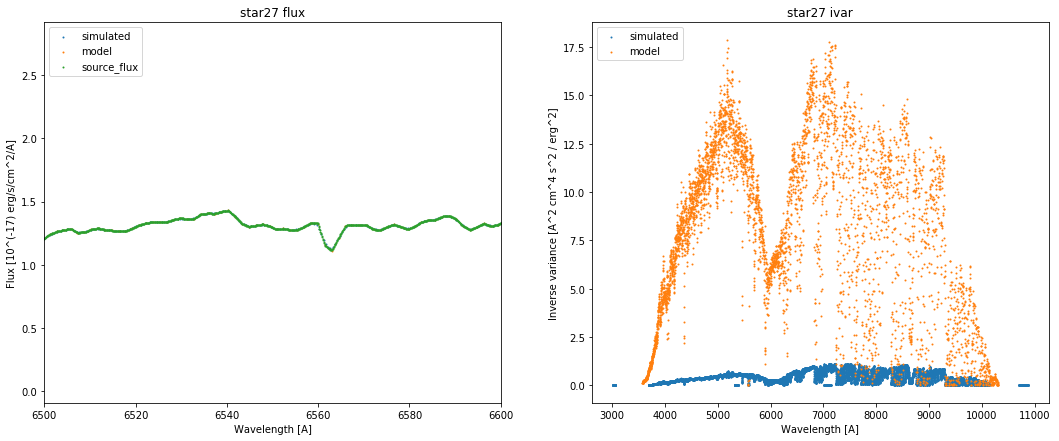

In [22]:
compare_fluxes(star27, 'star27')

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


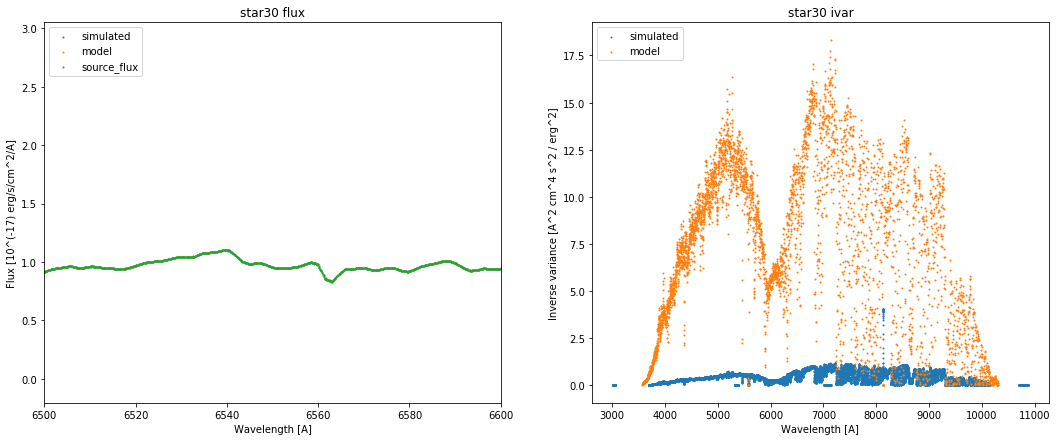

In [23]:
compare_fluxes(star30, 'star30')

/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:551: RuntimeWarning: divide by zero encountered in true_divide
  source_flux_to_photons.T * camera.throughput)).T
/Users/belaabolfathi/Documents/repos/specsim/specsim/simulator.py:555: RuntimeWarning: invalid value encountered in multiply
  output['flux_calibration'] * output['num_source_electrons'])


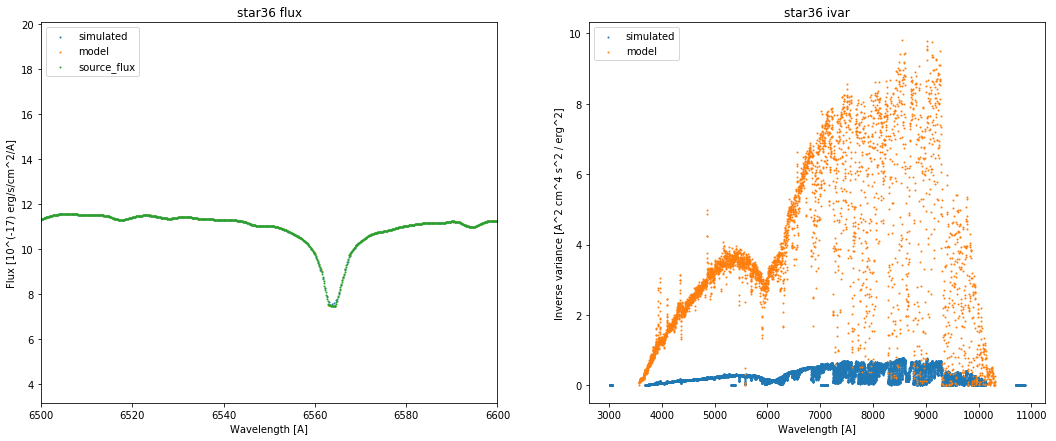

In [24]:
compare_fluxes(star36, 'star36')

### Model Flux

Change kernel to Python 2 (bossdata) to access Frame files

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bossdata

finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [178]:
def get_frame_data(plate, mjd, fiber, expidx, camera):
    
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures
    
    print(spec_name)

    name = exposures.get_exposure_name(expidx, camera, 'spCFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
    header = spCFrame.header
    data = spCFrame.get_valid_data(np.array([fiber]), include_sky=True,use_ivar=True, pixel_quality_mask=None)[0]
    wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    return(header, wave, flux, sky, ivar)

In [179]:
plate = 4055
mjd = 55359
fiber = 1

expidx = 0

hd_b1_0, wave_b1_0, flux_b1_0, sky_b1_0, ivar_b1_0 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_0, wave_r1_0, flux_r1_0, sky_r1_0, ivar_r1_0 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [185]:
ivar_r1_0

masked_array(data = [-- -- -- ..., -- -- --],
             mask = [ True  True  True ...,  True  True  True],
       fill_value = 1e+20)

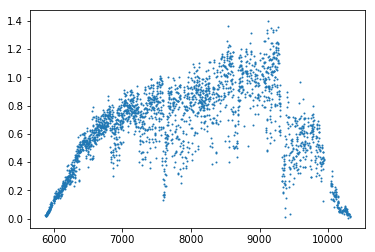

In [184]:
plt.scatter(wave_r1_0, ivar_r1_0, s=1)
plt.show()

In [5]:
expidx = 2

hd_b1_2, wave_b1_2, flux_b1_2, sky_b1_2, ivar_b1_2 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_2, wave_r1_2, flux_r1_2, sky_r1_2, ivar_r1_2 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [6]:
expidx = 3

hd_b1_3, wave_b1_3, flux_b1_3, sky_b1_3, ivar_b1_3 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_3, wave_r1_3, flux_r1_3, sky_r1_3, ivar_r1_3 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [7]:
expidx = 4

hd_b1_4, wave_b1_4, flux_b1_4, sky_b1_4, ivar_b1_4 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_4, wave_r1_4, flux_r1_4, sky_r1_4, ivar_r1_4 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [8]:
expidx = 5

hd_b1_5, wave_b1_5, flux_b1_5, sky_b1_5, ivar_b1_5 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='b1')
hd_r1_5, wave_r1_5, flux_r1_5, sky_r1_5, ivar_r1_5 = get_frame_data(plate=plate, mjd=mjd, fiber=fiber, expidx=expidx, 
                                                           camera='r1')

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits


In [24]:
# Trying to get num_exposures from plate file but doesn't seem to work..
# plate_spec_path = finder.get_plate_spec_path(plate=plate, mjd=mjd, )
# PlateFile = bossdata.plate.PlateFile(plate_spec_path)

In [15]:
print(hd_b1['EXPTIME'], hd_r1['EXPTIME'])
print(np.mean([hd_b1['RDNOISE0'], hd_b1['RDNOISE1'], hd_b1['RDNOISE2'], hd_b1['RDNOISE3']]))
print(np.mean([hd_r1['RDNOISE0'], hd_r1['RDNOISE1'], hd_r1['RDNOISE2'], hd_r1['RDNOISE3']]))

(900.84, 900.84)
1.9121675
2.5931125


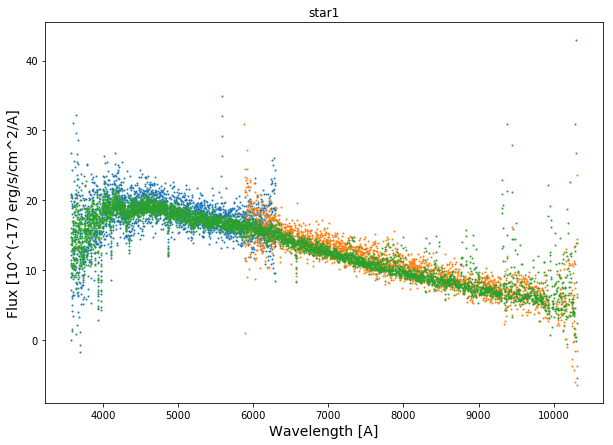

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(wave_b1, flux_b1, s=1)
plt.scatter(wave_r1, flux_r1, s=1)
plt.scatter(10**star1['loglam'], star1['flux'], s=1)
plt.title('Model', fontsize=14)
plt.xlabel('Wavelength [A]', fontsize=14)
plt.ylabel('Flux [10^(-17) erg/s/cm^2/A]', fontsize=14)
plt.title('star1')
plt.show()

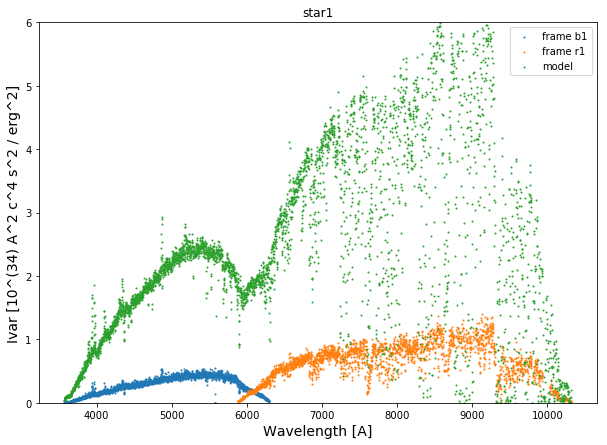

In [20]:
plt.figure(figsize=(10,7))
plt.scatter(wave_b1, ivar_b1, s=1, label='frame b1')
plt.scatter(wave_r1, ivar_r1, s=1, label='frame r1')
plt.scatter(10**star1['loglam'], star1['ivar'], s=1, label='model')
plt.title('Model', fontsize=14)
plt.xlabel('Wavelength [A]', fontsize=14)
plt.ylabel('Ivar [10^(34) A^2 c^4 s^2 / erg^2]', fontsize=14)
plt.title('star1')
plt.ylim(0, 6)
plt.legend()
plt.show()

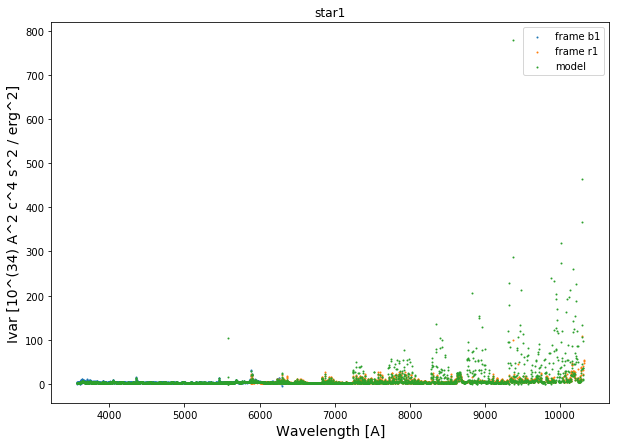

In [9]:
plt.figure(figsize=(10,7))
plt.scatter(wave_b1, sky_b1, s=1, label='frame b1')
plt.scatter(wave_r1, sky_r1, s=1, label='frame r1')
plt.scatter(10**star1['loglam'], star1['sky'], s=1, label='model')
plt.title('Model', fontsize=14)
plt.xlabel('Wavelength [A]', fontsize=14)
plt.ylabel('Ivar [10^(34) A^2 c^4 s^2 / erg^2]', fontsize=14)
plt.title('star1')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
eboss_sky = Table.read('/Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/eboss-spec-sky.dat', format='ascii')
star1_sky = Table.read('/Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/star1_sky.dat', format='ascii')

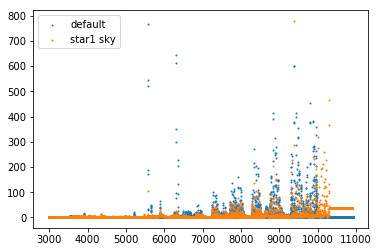

In [20]:
plt.scatter(eboss_sky['WAVELENGTH'], eboss_sky['FLUX'], s=1, label='default')
plt.scatter(star1_sky['WAVELENGTH'], star1_sky['FLUX'], s=1, label='star1 sky')
plt.legend()
plt.show()

## To do: 

- Try this for different stars
- Automate this for comparing variances and fluxes

### Simulated vs model variance

Get simulated variance from `simulator.camera_output`

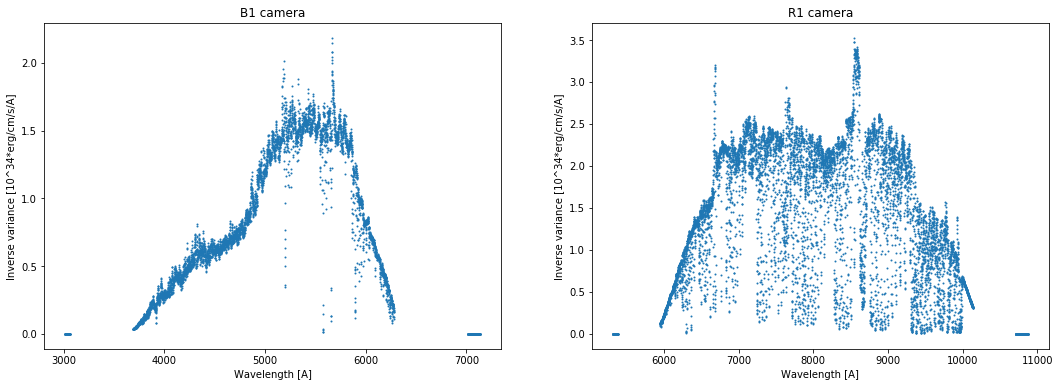

In [7]:
# index 0 is the blue camera, but ivar has dim (n,2) - is this referring to either the b1 or b2 camera? -- this was 
# because num_fibers was set to 2 (simulator.num_fibers)
b_ivar = blue_output['flux_inverse_variance'] 
b_wlen = blue_output['wavelength']
r_ivar = red_output['flux_inverse_variance'] 
r_wlen = red_output['wavelength']

# Usually we would multiply flux/std by scale, multiply var by scale**2 and divide ivar by scale**2, 
# but since units of ivar are in flux units (i.e. per angstrom) this is not necessary
# scale = np.gradient(sim30_b1_wlen)[0] 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.scatter(b_wlen, b_ivar[:,0]/10**34, s=1) # 1/10^34 = (1/10^17)^2
ax1.set_title('B1 camera')
ax1.set_xlabel('Wavelength [A]')
ax1.set_ylabel('Inverse variance [10^34*erg/cm/s/A]') # check if these units are right...
ax2.scatter(r_wlen, r_ivar[:,0]/10**34, s=1)
ax2.set_title('R1 camera')
ax2.set_xlabel('Wavelength [A]')
ax2.set_ylabel('Inverse variance [10^34*erg/cm/s/A]')
plt.show()

### Model variance

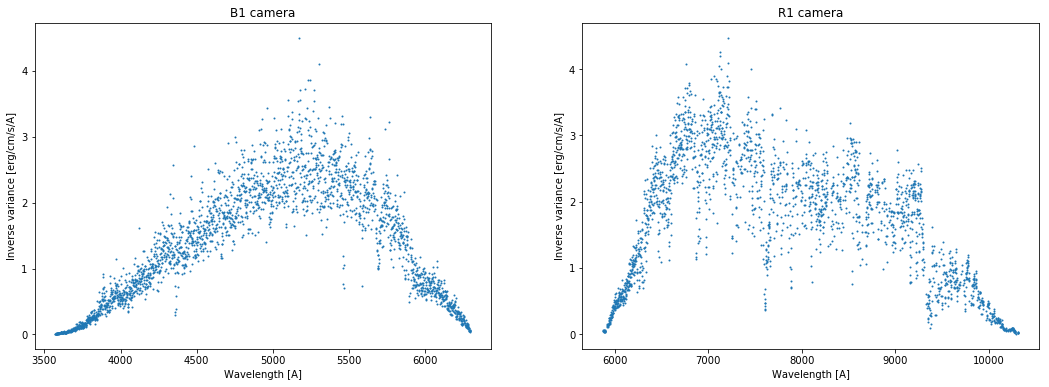

In [5]:
b1_scale = np.gradient(wave_b1)
r1_scale = np.gradient(wave_r1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.scatter(wave_b1, ivar_b1, s=1)
ax1.set_title('B1 camera')
ax1.set_xlabel('Wavelength [A]')
ax1.set_ylabel('Inverse variance [erg/cm/s/A]') # check if these units are right (might have a 10**17 in there...)
ax2.scatter(wave_r1, ivar_r1, s=1)
ax2.set_title('R1 camera')
ax2.set_xlabel('Wavelength [A]')
ax2.set_ylabel('Inverse variance [erg/cm/s/A]')
plt.show()

##### How is variance calculated???

#### Detected electrons: `sky + source + dark current + readout`

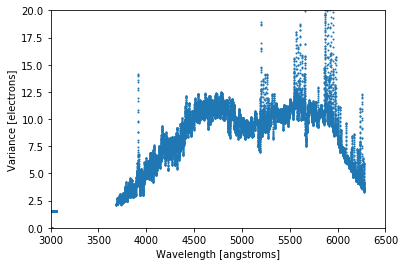

In [25]:
plt.scatter(sim30['wavelength'], sim30['num_source_electrons_b'][:,0] + 
            sim30['num_sky_electrons_b'][:,0] + 
            sim30['num_dark_electrons_b'][:,0]  + 
            sim30['read_noise_electrons_b'][:,0], s=1)
plt.xlim(3000,6500)
plt.ylim(0,20)
plt.xlabel('Wavelength [angstroms]')
plt.ylabel('Variance [electrons]')
plt.show()

In [24]:
len(star30['ivar']), len(sim30['wavelength'])
print(np.min(10**star30['loglam']), np.max(10**star30['loglam']))
print(np.min(sim30['wavelength']), np.max(sim30['wavelength']))

3571.91 10311.0
3000.0 10890.0


In [456]:
output1 = sim30['num_source_electrons_b'][:,0] + sim30['num_source_electrons_r'][:,0] + sim30['num_sky_electrons_b'][:,0] + sim30['num_sky_electrons_r'][:,0] + sim30['num_dark_electrons_b'][:,0] + sim30['num_dark_electrons_r'][:,0] + sim30['read_noise_electrons_b'][:,0] + sim30['read_noise_electrons_r'][:,0]
pred1 = np.interp(10**star30['loglam'], sim30['wavelength'], output1)

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


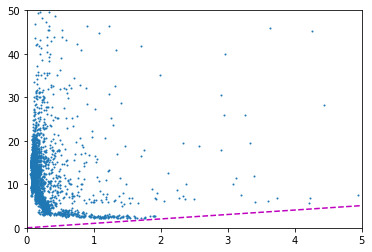

In [463]:
# Predicted vs Actual

plt.scatter(1/star30['ivar'], pred1, s=1)
plt.plot(np.linspace(0,50), 'm--')
plt.xlim(0,5)
plt.ylim(0,50);

# over-predicting??

#### Detected electrons (`sky + source + dark current`) + Readout Noise (`readout noise * neff`)

In [332]:
path = !echo $DESIMODEL

blue_instr = path[0] + '/data/specpsf/eboss-blue.fits'
blue_instr = Table.read(blue_instr)
red_instr = path[0] + '/data/specpsf/eboss-red.fits'
red_instr = Table.read(red_instr)

readnoise = 2.0 # electrons/pixel
blue_neff = blue_instr['neff_spatial']
red_neff = red_instr['neff_spatial']

b_wlen = np.load('/Users/belaabolfathi/Desktop/b_out.npy')
r_wlen = np.load('/Users/belaabolfathi/Desktop/r_out.npy')

#plt.scatter(b_wlen, blue_neff, s=1)
#plt.scatter(r_wlen, red_neff, s=1);

b_neff_interp = np.interp(sim30['wavelength'], b_wlen, blue_neff)
r_neff_interp = np.interp(sim30['wavelength'], r_wlen, red_neff)

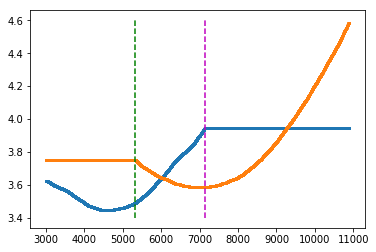

In [426]:
plt.scatter(sim30['wavelength'], b_neff_interp, s=1)
plt.plot((sim30['wavelength'][41370], sim30['wavelength'][41370]), (3.4, 4.6), 'm--')
plt.scatter(sim30['wavelength'], r_neff_interp, s=1);
plt.plot((sim30['wavelength'][23165], sim30['wavelength'][23165]), (3.4, 4.6), 'g--')

In [431]:
# Set everything above/below to zero:

b_neff_interp[41370:] = 0.0
r_neff_interp[:23165] = 0.0

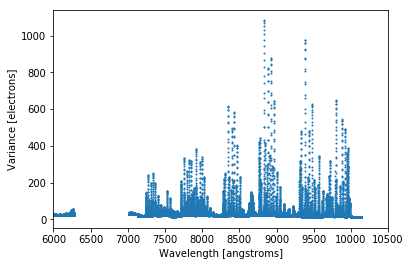

In [439]:
plt.scatter(sim30['wavelength'], sim30['num_source_electrons_b'][:,0] + sim30['num_source_electrons_r'][:,0] + 
            sim30['num_sky_electrons_b'][:,0] + sim30['num_sky_electrons_r'][:,0] + 
            sim30['num_dark_electrons_b'][:,0] + sim30['num_dark_electrons_r'][:,0] + 
            readnoise*b_neff_interp + readnoise*r_neff_interp, s=1)
plt.xlim(6000,10500)
plt.xlabel('Wavelength [angstroms]')
plt.ylabel('Variance [electrons]')
plt.show()

#### Add source + sky photons + dark current + readout

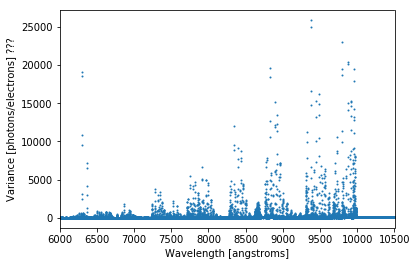

In [445]:
plt.scatter(sim30['wavelength'], sim30['num_source_photons'][:,0] + sim30['num_sky_photons'][:,0] + 
            sim30['num_dark_electrons_b'][:,0] + sim30['num_dark_electrons_r'][:,0] + readnoise, s=1)
plt.xlim(6000,10500)
plt.xlabel('Wavelength [angstroms]')
plt.ylabel('Variance [photons/electrons] ???')
plt.show()

## Find systematic way to: 

1) Find (bright) standard stars, collect data for ~100 exposures

2) Find a similar number of sky fibers to compare with specsim (sky) output

3) Interpolate sky background along blue + red overlap and generate data column to feed to config file

In [94]:
import bossdata

from astropy.table import Table, vstack
from astropy.io import ascii


finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [37]:
plate = 4055
mjd = 55359
fiber = 1

expidx = 0

In [16]:
def get_cframe_file(plate, mjd, fiber, expidx, camera):
    
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures
    
    print(spec_name)

    name = exposures.get_exposure_name(expidx, camera, 'spCFrame')
    path = mirror.get(finder.get_plate_path(plate, name))
    spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
    #header = spCFrame.header
    #data = spCFrame.get_valid_data(np.array([fiber]), include_sky=True,use_ivar=True, pixel_quality_mask=None)[0]
    #wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
    
    #return(spCFrame.plug_map)

    #return(header, wave, flux, sky, ivar)
    
    return(spCFrame)

def get_cframe_data(cframe, objtype):
    
    plug_map = cframe.plug_map
    return(plug_map)
    

In [31]:
# can't access 'CLASS' column from plate module...seems to only be accessible through spec module, which accesses 
# spAll and is only available per-exposure

# camera 2
cframe_1 = get_cframe_file(plate=plate, mjd=mjd, fiber=1, expidx=0, camera='b1')
plugmap_1 = get_cframe_data(cframe_1, 'SPECTROPHOTO_STD')

# camera 2
cframe_2 = get_cframe_file(plate=plate, mjd=mjd, fiber=600, expidx=0, camera='b2')
plugmap_2 = get_cframe_data(cframe_2, 'SPECTROPHOTO_STD')

plug_map = vstack([plugmap_1, plugmap_2])
star_indices = plug_map['OBJTYPE'] == 'SPECTROPHOTO_STD'
std_stars = plug_map[star_indices]

/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0001.fits
/sas/dr13/eboss/spectro/redux/v5_9_0/spectra/lite/4055/spec-4055-55359-0600.fits


In [18]:
std_indices = plugmap['OBJTYPE'] == 'SPECTROPHOTO_STD'
sky_indices = plugmap['OBJTYPE'] == 'SKY             '
std_strs = plugmap[std_indices]
sky = plugmap[sky_indices]

### Collect all star fibers on plate=4055 mjd=55359

In [92]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [55]:
# no sky fibers? doesn't seem to match output from plug map (objtype)...
sky_fibers = []
for i in range(1,1001):
    spec_name = finder.get_spec_path(plate, mjd, fiber=i, lite=True)
    if bossdata.spec.SpecFile(mirror.get(spec_name)).info['CLASS'] == 'STAR':
        sky_fibers.append(bossdata.spec.SpecFile(mirror.get(spec_name)).info['FIBERID'])

### Get spec files for these stars and write model

In [145]:
def write_model(plate, mjd, fiber):
    
    spec_file = '/Data'+finder.get_spec_path(plate, mjd, fiber=fiber, lite=True)
    data = Table.read(spec_file)
    
    wlen, flux = 10 ** data['loglam'], data['model']
    
    if wlen[0] > 3000.0:
        lo_wlen = np.arange(2999.9, wlen[0], 0.1)
        lo_flux = np.ones_like(lo_wlen) * flux[0]
        wlen = np.concatenate((lo_wlen, wlen))
        flux = np.concatenate((lo_flux, flux))
        
    if wlen[-1] < 10890.0:
        hi_wlen = np.arange(wlen[-1], 10891.9, 0.1)
        hi_flux = np.ones_like(hi_wlen) * flux[-1]
        wlen = np.concatenate((wlen, hi_wlen))
        flux = np.concatenate((flux, hi_flux))
        
    new_model = Table([wlen, flux], names=('WAVELENGTH', 'FLUX'))
    
    new_model.write('models/star'+str(fiber)+'_model.dat', format='ascii', overwrite=True)

In [146]:
for i in range(len(sky_fibers)):
    write_model(plate, mjd, sky_fibers[i])

### Get sky data from CFrame files

In [197]:
def get_cframe_data(plate, mjd, fiber, expidx, cameras):
    
    spec_name = finder.get_spec_path(plate, mjd, fiber, lite=True)
    exposures = bossdata.spec.SpecFile(mirror.get(spec_name)).exposures

    for cam in cameras:
        name = exposures.get_exposure_name(expidx, cam, 'spCFrame')
        path = mirror.get(finder.get_plate_path(plate, name))
        spCFrame = bossdata.plate.FrameFile(path, calibrated=True)
        data = spCFrame.get_valid_data(np.array([fiber]), include_sky=True,use_ivar=True, pixel_quality_mask=None)[0]
        wave, flux, sky, ivar = data['wavelength'], data['flux'], data['sky'], data['ivar']
        
        filename = 'star'+str(fiber)+'_expid'+str(expidx)+'_'+cam

        ascii.write(Table([wave, flux, sky, ivar], 
                        names=('wavelength', 'flux', 'sky', 'ivar')), 'cframe_files/'+filename+'.fits')

In [199]:
for i in range(len(sky_fibers)):
    if sky_fibers[i] < 501:
        cameras = ['b1', 'r1']
        get_cframe_data(plate, mjd, sky_fibers[i], 0, cameras)
    else:
        cameras = ['b2', 'r2']
        get_cframe_data(plate, mjd, sky_fibers[i], 0, cameras)

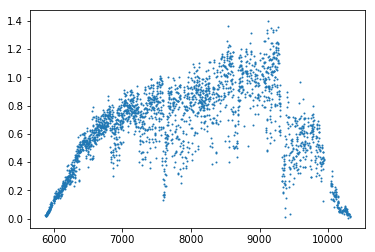

In [203]:
r1 = Table.read('cframe_files/star1_expid0_r1.fits', format='ascii')
plt.scatter(r1['wavelength'], r1['ivar'], s=1)
plt.show()

### scratch

In [17]:
def resample_binned(edges_out, edges_in, hist_in, axis=-1, zero_pad=True):
    """Flux conserving linear resampler of binned data.
    Parameters
    ----------
    edges_out : array
        1D array of M >= 2 output bin edges, in increasing order.
    edges_in : array
        1D array of N >= 2 input bin edges, in increasing order.
    hist_in : array
        Array with N-1 input bin values indexed by the specified axis.
    axis : int
        Axis of hist_in used to index input histogram values.
    zero_pad : bool
        When True, allow the output edges to extend beyond the input
        edges and assume that the input histogram is zero outside of
        its extent.  When False, raises a ValueError if extrapolation
        would be required.
    Returns
    -------
    array
        1D array of M-1 resampled bin values.
    """
    # Check input 1D arrays.
    edges_out = np.asarray(edges_out)
    edges_in = np.asarray(edges_in)
    if edges_out.ndim != 1:
        raise ValueError('Expected 1D edges_out.')
    if edges_in.ndim != 1:
        raise ValueError('Expected 1D edges_in.')
    if len(edges_out) < 2:
        raise ValueError('Need at least one output bin.')
    if len(edges_in) < 2:
        raise ValueError('Need at least one input bin.')
    binsize_out = np.diff(edges_out)
    if np.any(binsize_out <= 0):
        raise ValueError('Expecting increasing edges_out.')
    binsize_in = np.diff(edges_in)
    if np.any(binsize_in <= 0):
        raise ValueError('Expecting increasing edges_in.')
    if not zero_pad and ((edges_out[0] < edges_in[0]) or
                         (edges_out[-1] > edges_in[-1])):
        raise ValueError(
            'Ouput bins extend beyond input bins but zero_pad is False.')
    ## DOESN'T SEEM LIKE THIS IS A STRAIGHTFORWARD APPLICATION BECAUSE THE NEW GRID WILL NEVER LIE WITHIN 
    ## THE NOMINAL GRID 
    if (edges_out[0] >= edges_in[-1]) or (edges_out[-1] <= edges_in[0]):
        raise ValueError('Input and output bins do not overlap.')
    # Check input histogram(s) and put index in axis 0. Note that we
    # use moveaxis instead of rollaxis since it is easier to invert.
    
    ## MOVING ON THOUGH -- LET'S SEE WHAT HE DOES HERE:
    hist_in = np.asarray(hist_in)
    ## THIS JUST MAKES SURE THAT DESIRED AXIS IS IN THE FIRST POSITION
    hist_in_rolled = np.moveaxis(hist_in, axis, 0)
    if len(hist_in_rolled) != len(edges_in) - 1:
        raise ValueError(
            'Unexpected length of hist_in along axis {}.'.format(axis))
    # Align output edges to input edges.
    idx = np.searchsorted(edges_in, edges_out)
    # Loop over output bins.
    nin = len(edges_in) - 1
    nout = len(edges_out) - 1
    hist_out_rolled_shape = (nout,) + hist_in_rolled.shape[1:]
    hist_out_rolled = np.zeros(hist_out_rolled_shape)
    hi = idx[0]
    for i in range(nout):
        lo = hi
        hi = idx[i + 1]
        if (lo > nin) or (hi == 0):
            # This bin does not overlap the input.
            continue
        if lo == hi:
            # Output bin is fully embedded within an input bin:
            # give it a linear share.
            hist_out_rolled[i] = (
                binsize_out[i] / binsize_in[lo - 1] * hist_in_rolled[lo - 1])
            continue
        # Calculate fraction of first input bin overlapping this output bin.
        if lo > 0:
            hist_out_rolled[i] += (
                hist_in_rolled[lo - 1] / binsize_in[lo - 1] * (
                    edges_in[lo] - edges_out[i]))
        # Calculate fraction of last input bin overlaping this output bin.
        if hi <= nin:
            hist_out_rolled[i] += (
                hist_in_rolled[hi - 1] / binsize_in[hi - 1] * (
                    edges_out[i + 1] - edges_in[hi - 1]))
        # Add input bins fully contained within this output bin.
        if hi > lo + 1:
            hist_out_rolled[i] += np.sum(hist_in_rolled[lo:hi - 1], axis=0)
    # Return our unrolled output histogram.
    return np.moveaxis(hist_out_rolled, axis, 0)

In [70]:
simulator = specsim.simulator.Simulator('eboss', num_fibers=1)
simulator.atmosphere
simulator.simulate()

blue_output = simulator.camera_output[0]
red_output = simulator.camera_output[1]

sim = simulator.simulated

b_wlen, r_wlen = blue_output['wavelength'], red_output['wavelength']
b_flux, r_flux = blue_output['observed_flux'], red_output['observed_flux']

/Users/belaabolfathi/anaconda3/envs/galsim/lib/python3.6/site-packages/speclite/filters.py:1461: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


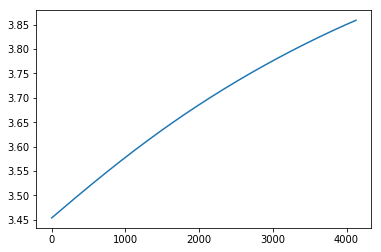

In [116]:
#plt.plot(b_wlen)
plt.plot(output_wlen)

In [118]:
len(b_flux), len(b_wlen)

(8252, 8252)

In [123]:
8252/4, 2063

2063.0

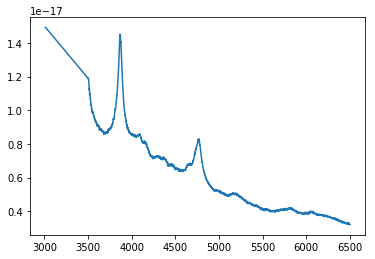

In [117]:
plt.plot(b_wlen, b_flux)
#plt.plot(np.log10(b_wlen), np.log10(b_flux))
plt.show()

This isn't gonna work - the input and output bins don't overlap.

Do this instead:
Take output wavelength grid. Find index where log of nominal wavelength equals value of output wavelength grid. Then add the flux value at the same index into the output wavelength bin.

In [92]:
nominal_wlen = b_wlen
output_wlen = np.load('b_loglam.npy')

In [125]:
len(output_wlen), len(nominal_wlen)

(4130, 8252)

Ok good. Now take log of nominal wavelength, then do 'search_sorted' to find indices. 

In [126]:
log_nom = np.log10(b_wlen)

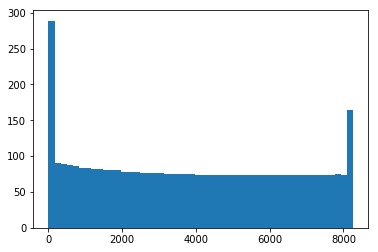

In [139]:
plt.hist(np.searchsorted(log_nom, output_wlen), bins=50)
plt.show()

In [177]:
np.searchsorted?

In [182]:
np.searchsorted(output_wlen, log_nom)

array([ 197,  198,  198, ..., 4041, 4041, 4042])

In [183]:
output_wlen[196:200]

array([3.47863735, 3.47876544, 3.47889352, 3.4790216 ])

In [186]:
log_nom[0]

3.4787251788694604

In [184]:
l = [np.argmin(np.abs(output_wlen - log_nom[i])) for i in range(len(log_nom))]

In [192]:
downsampled_flux = np.zeros(len(output_wlen), dtype=float64)

In [193]:
for i, idx in enumerate(l):
    downsampled_flux[idx] += b_flux[i]

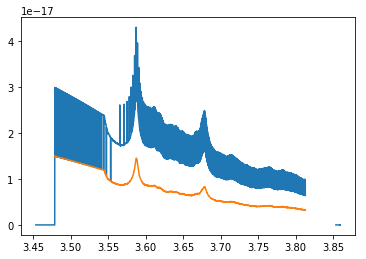

In [200]:
plt.plot(output_wlen, downsampled_flux)
plt.plot(log_nom, b_flux)
plt.show()

In [203]:
np.sum(b_flux[~np.isnan(b_flux)])

4.93408180957786e-14

In [208]:
np.sum(downsampled_flux[~np.isnan(downsampled_flux)])

4.933761225988077e-14

Now, downsample `downsampled_flux`:

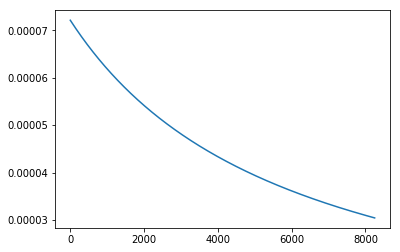

In [151]:
plt.plot(np.diff(log_nom))
plt.show()

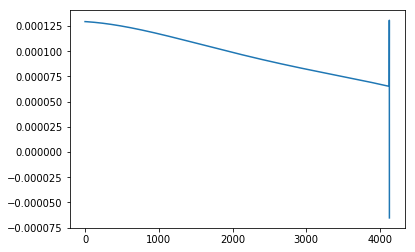

In [152]:
plt.plot(np.diff(output_wlen)) ## not completely linear in log-lambda..

In [148]:
output_wlen[:7]

array([3.45339679, 3.45352612, 3.45365545, 3.45378478, 3.4539141 ,
       3.45404342, 3.45417273])

In [94]:
output_diff = np.diff(output_wlen)

In [95]:
output_wlen = np.insert(output_wlen, 0, output_wlen[0] - output_diff[0])
output_wlen = np.insert(output_wlen, -1, output_wlen[-1] + output_diff[-1])

In [96]:
log_nom = np.log10(b_wlen)

In [97]:
len(log_nom), len(output_wlen)

(8252, 4130)

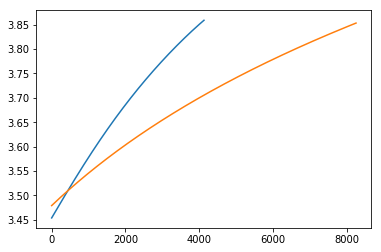

In [100]:
plt.plot(output_wlen)
plt.plot(log_nom)
plt.show()

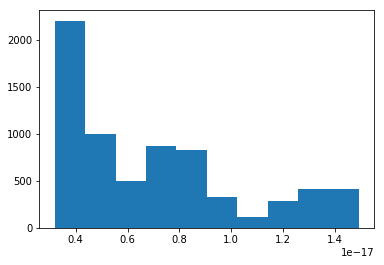

In [110]:
plt.hist(b_flux[~np.isnan(b_flux)])
plt.show()

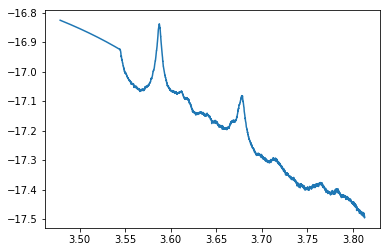

In [102]:
plt.hist(b_flux[~np.isnan(b_flux)])
plt.show()

In [41]:
star1  = Table.read('/Users/belaabolfathi/Downloads/spec-4055-55359-0001.fits', format='fits')

In [55]:
loglam = star1['loglam'][:3004]

In [58]:
hist, _ = np.histogram(b_flux, bins=b_wlen)

In [59]:
len(hist), len(b_wlen)

(8251, 8252)

In [60]:
resample_binned(loglam, b_wlen, hist)

ValueError: Input and output bins do not overlap.

In [61]:
loglam[0], b_wlen[-1]

(3.5529, 7136.6)

In [62]:
loglam[-1], b_wlen[0]

(3.8532, 3011.1000000000004)